In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'y-', label='input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'g-', linewidth=2, label='FIR Output')

    plt.legend()

Number of samples:  200000


<IPython.core.display.Javascript object>


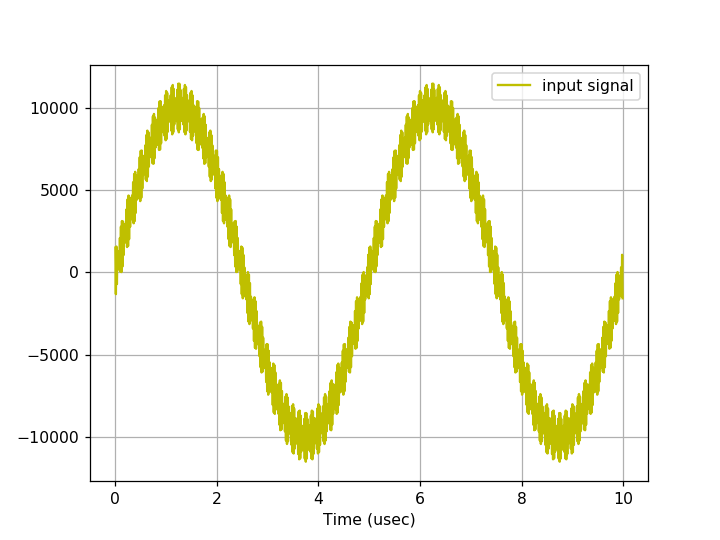

In [2]:
import numpy as np

T = 0.002
fs = 100e6
n = int(T*fs)
t = np.linspace(0, T, n, endpoint=False)
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t)
samples = samples.astype(np.int32)
print('Number of samples: ', len(samples))

plot_to_notebook(t, samples, 1000)


SOFTWARE FIR EXECUTION TIME:  0.09813237190246582


/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:1367: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


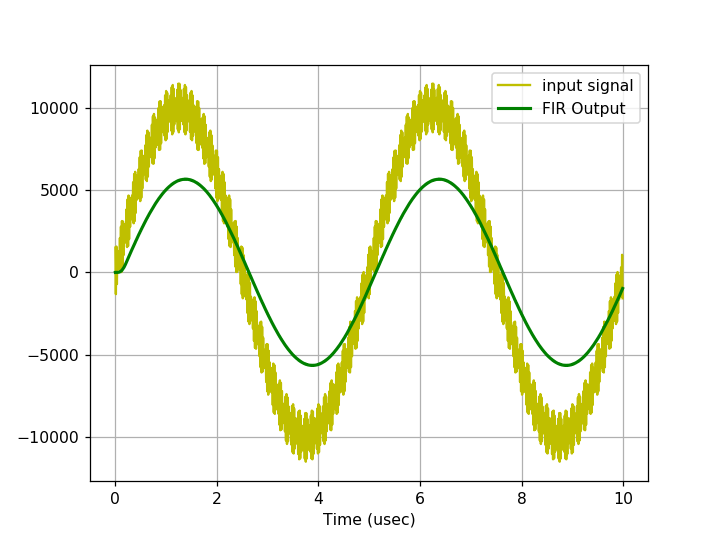

In [3]:
from scipy.signal import lfilter

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]
import time

start_time = time.time()
sw_fir_output = lfilter(coeffs, 70e3, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print("SOFTWARE FIR EXECUTION TIME: ", sw_exec_time)

plot_to_notebook(t, samples, 1000, out_signal=sw_fir_output)

In [5]:
from pynq import Overlay
import pynq.lib.dma

#Load the overlay
overlay=Overlay('/home/xilinx/jupyter_notebooks/Sidharth_and_Saksham/FIR_Accel_Vivado/design_1.bit')


#Load the FIR DMA
dma=overlay.filter.fir_dma


Hardware FIR execution time:  0.0044252872467041016
Hardware acceleration factor:  22.17536770648133


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


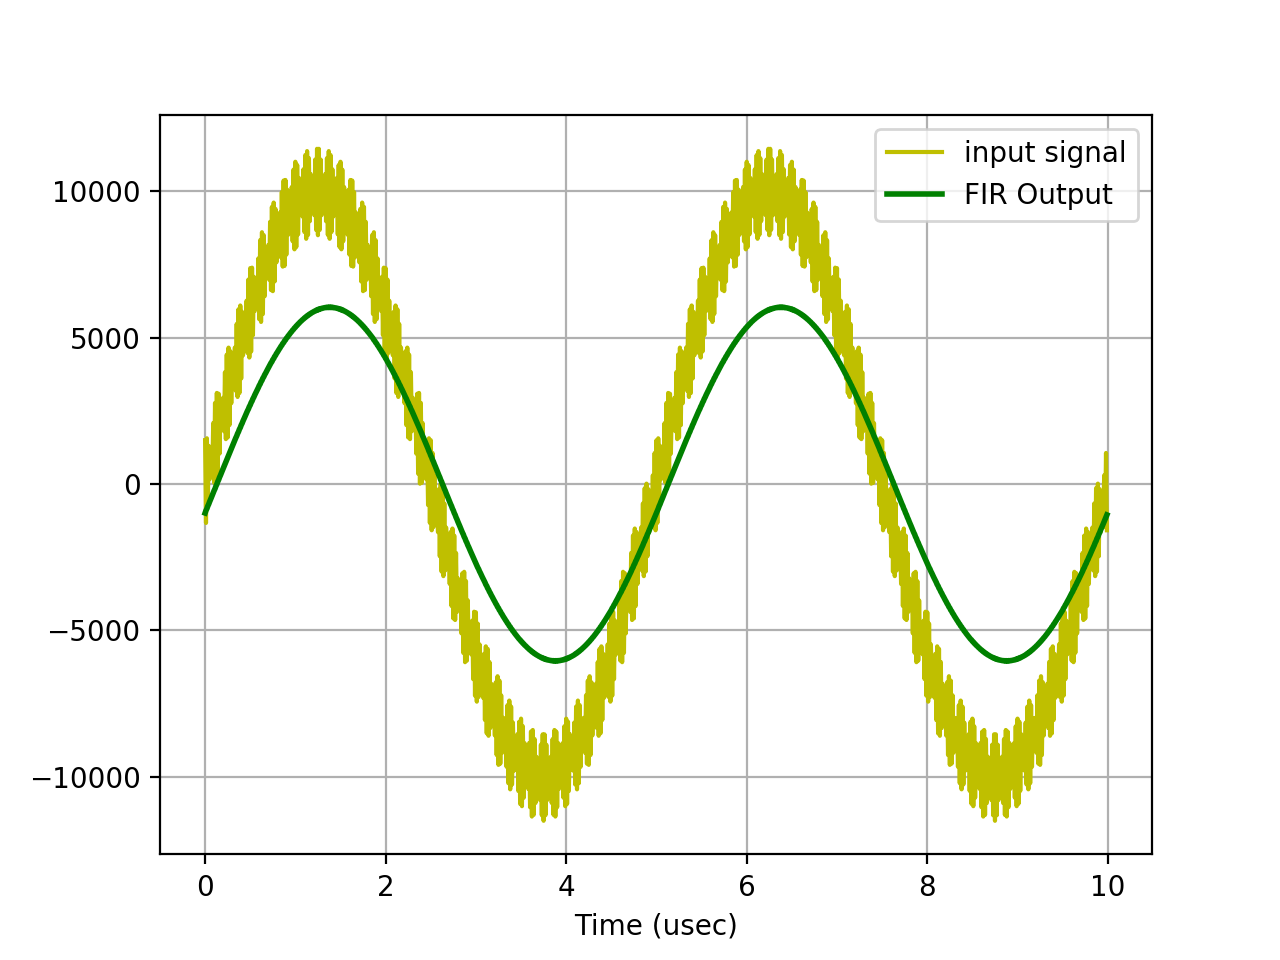

In [8]:
from pynq import Xlnk
import numpy as np

xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

np.copyto(in_buffer, samples)

import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time - start_time

print("Hardware FIR execution time: ",hw_exec_time)
print("Hardware acceleration factor: ", sw_exec_time/hw_exec_time)

plot_to_notebook(t, samples, 1000, out_signal=out_buffer)
in_buffer.close()
out_buffer.close()